In [1]:
using Pkg
Pkg.activate("..")

  Activating environment at `~/git/AlgebraicDynamics.jl/Project.toml`


In [2]:
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using LabelledArrays

using Catlab.Graphics
using DelayDiffEq, DifferentialEquations
using Plots

┌ Info: Precompiling AlgebraicDynamics [5fd6ff03-a254-427e-8840-ba658f502e32]
└ @ Base loading.jl:1342
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


In [3]:
malaria_pattern = WiringDiagram([], [])
add_box!(malaria_pattern, Box(:mosquitos, [:x], [:z]))
add_box!(malaria_pattern, Box(:humans, [:z], [:x]))
add_wires!(malaria_pattern, Pair(
        (1, 1) => (2, 1),
        (2, 1) => (1, 1)))

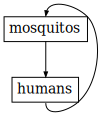

In [4]:
to_graphviz(malaria_pattern)

# ODEProblem

The Ross-Macdonald (RM) model is the canonical model of malaria transmission, first expressed by Sir Ronald Ross in 1911. The simplest form of the model is given by a system of 2 nonlinear ordinary differential equations describing $Z$, parasite prevalence in the mosquito vector population, and $X$, parasite prevalence in the vertebrate host population.

$$
\dot{X} = mabZ(1-X) -rX \\
\dot{Z} = acX(e^{-gn} - Z) - gZ
$$

The RM model is of supreme importance to modeling of malaria and other mosquito transmitted diseases because it is the simplest model that retains the fundamental processes involved in transmission: recovery of infected hosts, death of infected mosquitoes, and parasite transmission between discordant pairs of vectors and hosts. In this sense it represents the irreducible complexity to modeling mosquito borne diseases, such that any simpler model would be insufficient.

The model assumes that mosquitoes take bloodmeals (bites) on vertebrate hosts with rate $a$. Therefore, the per-capita rate at which susceptible mosquitoes become infected is $acX$, where $c$ is the transmission efficiency from infectious humans to susceptible mosquitoes (probability of parasites successfully invading the mosquito given a bite occurs) and $X$ is the probability the bite lands on an infectious human. $1-Z$ is the proportion of mosquitoes who are susceptible but given an incubation period of $n$ days during which mosquitoes suffer per-capita mortality at rate $g$, only a proportion $e^{-gn}$ survive incubation to become infectious. Therefore the classic RM model will have statics that are consistent with the incorporation of an incubation period of fixed duration, but dynamics will not, as the delay is not incorporated into the equations.

Susceptible humans acquire infection at a rate $mabZ$, where $m = M/H$, the ratio of mosquitoes to humans, $a$ is as before, and $b$ is the transmission efficiency from infectious mosquitoes to susceptible humans. Therefore $mabZ$ gives the per-capita rate at which susceptible humans recieve parasites from the mosquito population. Infectious humans recover at a rate $r$ (the rate at which the immune system clears parasites). Because $m$ is considered a constant parameter, the model ignores seasonal fluctuations in mosquito (or host) population sizes. However, because the timescale of host dynamcis is typically slow in relation to mosquito dynamics, the approximation i 

The model's threshold criterion between the trivial equilibrium where both $Z,X$ are equal to zero (no disease) and the endemic equilibrium can be expressed by the basic reproductive number, giving the expected number of secondary infections arising from the introduction of a single infectious human.

$$
R_{0} = \frac{ma^{2}bce^{-gn}}{rg}
$$

The endemic equilibrium is therefore:

$$
\bar{X}= \frac{R_{0}-1}{R_{0} + a/g} \\
\bar{Z} = \frac{ac\bar{X}}{g + ac\bar{X}} e^{-gn}
$$

From these equations, the nonlinear relationships that characterize observed malaria transmission can be understood. The model can be implemented in [AlgebraicDynamics.jl](https://github.com/AlgebraicJulia/AlgebraicDynamics.jl) as follows:

In [5]:
dZdt = function(u,x,p,t)
    Z = u[1]
    x = x[1]
    [p.a*p.c*x*(exp(-p.g*p.n) - Z) - p.g*Z]
end

dXdt = function(u,x,p,t)
    X = u[1]
    z = x[1]
    [p.m*p.a*p.b*z*(1 - X) - p.r*X]
end
    

mosquito_dynamics = ContinuousMachine{Float64}(
    1,
    1,
    1,
    dZdt,
    (u,p,t) -> u
);

human_dynamics = ContinuousMachine{Float64}(
    1,
    1,
    1,
    dXdt,
    (u,p,t) ->  u
);



In [6]:
malaria_model = oapply(malaria_pattern, 
    Dict(:humans => human_dynamics, :mosquitos => mosquito_dynamics)
)

ContinuousMachine(ℝ^2 × ℝ^0 → ℝ^2)

In [7]:
params = LVector(a = 0.3, b = 0.55, c = 0.15, 
    g = 0.1, n = 10, r = 1.0/200, m = 0.5)

u0 = [0.1, 0.3]
tspan = (0.0, 365.0*2)

(0.0, 730.0)

In [8]:
prob = ODEProblem(malaria_model, u0, tspan, params)
sol = solve(prob, Tsit5());

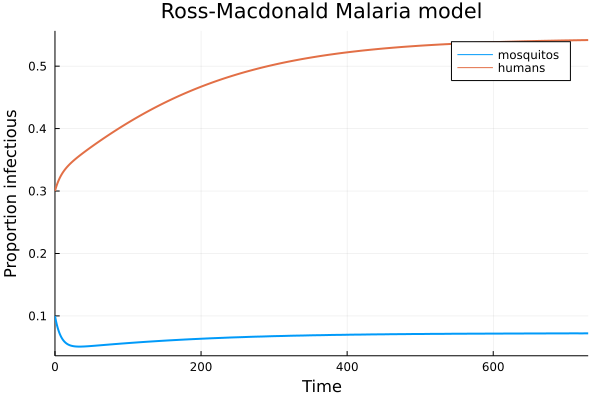

In [9]:
plot(
    sol, lw=2,
    title = "Ross-Macdonald Malaria model", 
    label=["mosquitos" "humans"], 
    xlabel = "Time", ylabel = "Proportion infectious"
)

# DDEProblem

In [134]:
dzdt_delay = function(u,i,h,p,t)
    y = u[1]; y_delay = h(p,t - p.n)[1]
    z = u[2]; z_delay = h(p,t - p.n)[2]
    x = i[1]; x_delay = i[1]
    
    [p.a*p.c*x*(1 - y - z) - 
        p.a*p.c*x_delay*(1 - y_delay - z_delay)*exp(-p.g*p.n) - 
        p.g*y,
    p.a*p.c*x_delay*(1 - y_delay - z_delay)*exp(-p.g*p.n) -
        p.g*z]
end

dxdt_delay = function(u,x,h,p,t)
    x = u[1]
    z = x[1]
    [p.m*p.a*p.b*z*(1 - x) - p.r*x]
end

mosquito_dynamics = ContinuousDelayMachine{Float64}(
    1,
    2,
    1,
    dzdt_delay,
    (u,h,p,t) -> [u[2]]
);

human_dynamics = ContinuousDelayMachine{Float64}(
    1,
    1,
    1,
    dxdt_delay,
    (u,h,p,t) -> u
);


In [135]:
malaria_model = oapply(malaria_pattern, 
    Dict(:humans => human_dynamics, :mosquitos => mosquito_dynamics)
);

In [136]:
params = LVector(a = 0.3, b = 0.55, c = 0.15, 
    g = 0.1, n = 10, r = 1.0/200, m = 0.5)

u0 = [0.09, 0.01, 0.3]
tspan = (0.0, 365.0*2)
hist(p,t) = u0;

In [137]:
prob = DDEProblem(malaria_model, u0, [], hist, tspan, params)
sol = solve(prob, Tsit5());

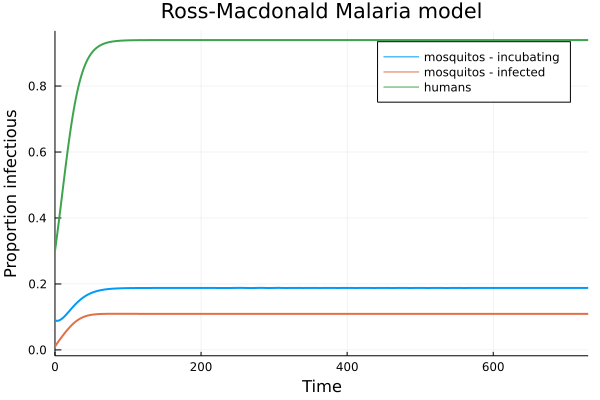

In [141]:
plot(
    sol, lw=2, 
    title = "Ross-Macdonald Malaria model", 
    label=["mosquitos - incubating" "mosquitos - infected" "humans"], 
    xlabel = "Time", ylabel = "Proportion infectious"
)